In [14]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg ,FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr_datasets.partitioner import IidPartitioner

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cpu
Flower 1.15.2 / PyTorch 2.6.0


In [15]:
# Parameters
NUM_PARTITIONS = 20  # Number of clients
BATCH_SIZE = 32
FL_ROUNDS = 100
Local_Epochs = 10
NUM_SELECTED_CLIENTS = 10

In [16]:
# Create an IID partitioner with specified number of partitions
iid_partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS)
fds = FederatedDataset(dataset="cifar10", partitioners={"train": iid_partitioner})

In [17]:
def load_iid_datasets(partition_id: int):
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    
    # Define PyTorch transforms
    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    
    # Create data loaders
    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    
    return trainloader, valloader

def get_testloader():
    # Define PyTorch transforms
    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Load test set
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    
    return testloader


In [7]:
# Load data for all clients and calculate label distributions
from collections import Counter

label_distributions = []
for client_id in range(NUM_PARTITIONS):
    trainloader, _ = load_iid_datasets(partition_id=client_id)
    labels = []
    for batch in trainloader:
        labels.extend(batch["label"].tolist())  # Convert tensor to list
    label_counts = {i: labels.count(i) for i in range(10)}  # Count occurrences of each label
    label_distributions.append(label_counts)


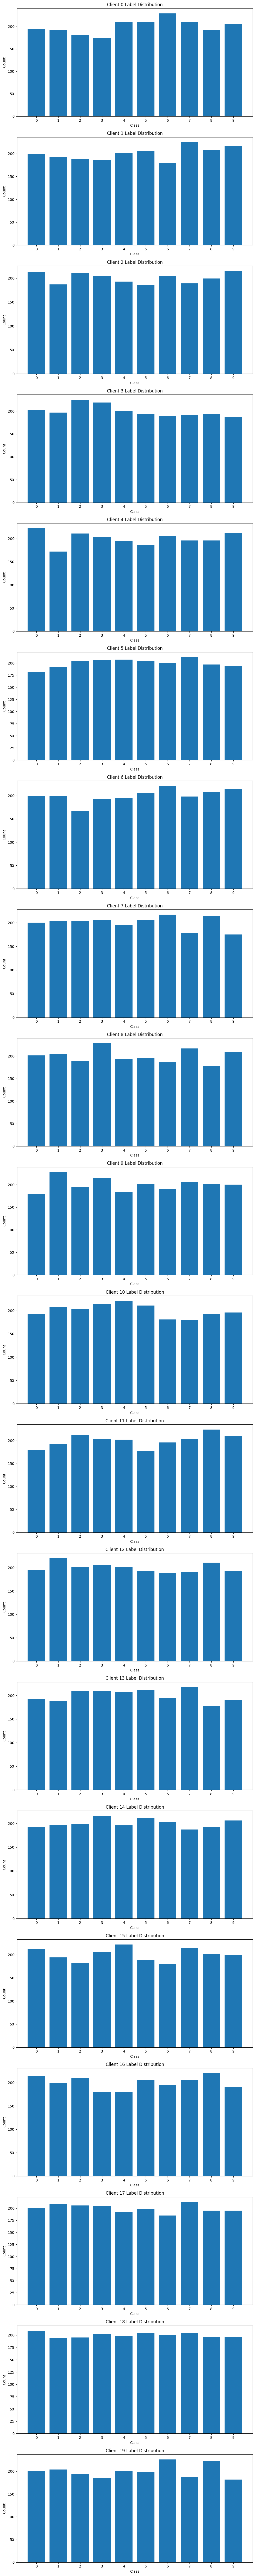

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot label distributions for each client
fig, axs = plt.subplots(NUM_PARTITIONS, 1, figsize=(10, 100))
for i, (ax, distribution) in enumerate(zip(axs, label_distributions)):
    # Explicitly set x-axis ticks and labels
    ax.bar(distribution.keys(), distribution.values())
    ax.set_xticks(range(10))  # Set ticks for 0 to 9
    ax.set_xticklabels(range(10))  # Set labels for 0 to 9
    ax.set_title(f"Client {i} Label Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [18]:
def load_datasets(partition_id: int):
    return load_iid_datasets(partition_id)

## Step 3: Define the neural network using PyTorch


In [19]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to train the model
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

# Function to evaluate the model
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Function to get model parameters
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Function to set model parameters
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [20]:
# Define the FlowerClient class
class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs= Local_Epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)

    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]

    trainloader, valloader = load_datasets(partition_id)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [21]:
# Lists to store the results
loss_history = []
accuracy_history = []

# The `evaluate` function will be called by Flower after every round of training in Server
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    testloader = get_testloader()
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    # Store the results
    loss_history.append(loss)
    accuracy_history.append(accuracy)
    return loss, {"accuracy": accuracy}

# Create an instance of the model and get the parameters
params = get_parameters(Net())

def server_fn(context: Context) -> ServerAppComponents:
    # Create the FedAvg strategy
    strategy = FedProx(
        fraction_fit=NUM_SELECTED_CLIENTS/NUM_PARTITIONS,
        fraction_evaluate=1/NUM_PARTITIONS,
        min_fit_clients=NUM_SELECTED_CLIENTS,
        min_evaluate_clients=1,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        proximal_mu=0.01
    )
    # Configure the server for 150 rounds of training
    config = ServerConfig(num_rounds=FL_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

In [22]:
# Create ServerApp
server = ServerApp(server_fn=server_fn)

In [23]:
# Specify the resources each of your clients need
# Allocate all 8 CPU cores to each client
backend_config = {"client_resources": {"num_cpus": 8}}
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 1, "num_cpus": 6}}

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,  # Number of clients
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=100, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07213871459960937, {'accuracy': 0.0999}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


Server-side evaluation loss 0.07213871459960937 / accuracy 0.0999
(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.06883102655410767, accuracy 0.19
(ClientAppActor pid=65384) Epoch 2: train loss 0.06363692134618759, accuracy 0.2655
(ClientAppActor pid=65384) Epoch 3: train loss 0.05880860984325409, accuracy 0.3165
(ClientAppActor pid=65384) Epoch 4: train loss 0.05504341050982475, accuracy 0.3465
(ClientAppActor pid=65384) Epoch 5: train loss 0.052534352988004684, accuracy 0.392
(ClientAppActor pid=65384) Epoch 6: train loss 0.05045434460043907, accuracy 0.426
(ClientAppActor pid=65384) Epoch 7: train loss 0.04869221895933151, accuracy 0.44
(ClientAppActor pid=65384) Epoch 8: train loss 0.045848648995161057, accuracy 0.4735
(ClientAppActor pid=65384) Epoch 9: train loss 0.04354599863290787, accuracy 0.506
(ClientAppActor pid=65384) Epoch 10: train loss 0.04222404211759567, accuracy 0.5245
(ClientAppActor pid=65384

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.044007595628499985, accuracy 0.495


INFO :      fit progress: (1, 0.057151234316825866, {'accuracy': 0.3362}, 74.72342349999963)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.057151234316825866 / accuracy 0.3362
(ClientAppActor pid=65384) [Client 16] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.051871322095394135, accuracy 0.4125
(ClientAppActor pid=65384) Epoch 2: train loss 0.0478300116956234, accuracy 0.451
(ClientAppActor pid=65384) Epoch 3: train loss 0.045128170400857925, accuracy 0.487
(ClientAppActor pid=65384) Epoch 4: train loss 0.043145712465047836, accuracy 0.5085
(ClientAppActor pid=65384) Epoch 5: train loss 0.040402889251708984, accuracy 0.5405
(ClientAppActor pid=65384) Epoch 6: train loss 0.03845697641372681, accuracy 0.5595
(ClientAppActor pid=65384) Epoch 7: train loss 0.03606649115681648, accuracy 0.5845
(ClientAppActor pid=65384) Epoch 8: train loss 0.03367406129837036, accuracy 0.6215
(ClientAppActor pid=65384) Epoch 9: train loss 0.03152340278029442, accuracy 0.6445
(ClientAppActor pid=65384) Epoch 10: train loss 0.029304007068276405, accuracy 0.6735
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.028606710955500603, accuracy 0.681


INFO :      fit progress: (2, 0.044687282961606976, {'accuracy': 0.4983}, 145.05185008399712)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.044687282961606976 / accuracy 0.4983
(ClientAppActor pid=65384) [Client 11] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.04439068213105202, accuracy 0.496
(ClientAppActor pid=65384) Epoch 2: train loss 0.03880949318408966, accuracy 0.5525
(ClientAppActor pid=65384) Epoch 3: train loss 0.036201074719429016, accuracy 0.5935
(ClientAppActor pid=65384) Epoch 4: train loss 0.03324069827795029, accuracy 0.6215
(ClientAppActor pid=65384) Epoch 5: train loss 0.030041612684726715, accuracy 0.6575
(ClientAppActor pid=65384) Epoch 6: train loss 0.027052169665694237, accuracy 0.694
(ClientAppActor pid=65384) Epoch 7: train loss 0.024235354736447334, accuracy 0.7275
(ClientAppActor pid=65384) Epoch 8: train loss 0.021176643669605255, accuracy 0.7695
(ClientAppActor pid=65384) Epoch 9: train loss 0.018355321139097214, accuracy 0.8045
(ClientAppActor pid=65384) Epoch 10: train loss 0.015506234019994736, accuracy 0.8445
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.016768380999565125, accuracy 0.823


INFO :      fit progress: (3, 0.046418549382686615, {'accuracy': 0.5323}, 216.42085591700015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.046418549382686615 / accuracy 0.5323
(ClientAppActor pid=65384) [Client 13] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.041080716997385025, accuracy 0.5445
(ClientAppActor pid=65384) Epoch 2: train loss 0.033271849155426025, accuracy 0.635
(ClientAppActor pid=65384) Epoch 3: train loss 0.028386767953634262, accuracy 0.6955
(ClientAppActor pid=65384) Epoch 4: train loss 0.025038955733180046, accuracy 0.7315
(ClientAppActor pid=65384) Epoch 5: train loss 0.021211329847574234, accuracy 0.7815
(ClientAppActor pid=65384) Epoch 6: train loss 0.018204625695943832, accuracy 0.8155
(ClientAppActor pid=65384) Epoch 7: train loss 0.014884723350405693, accuracy 0.849
(ClientAppActor pid=65384) Epoch 8: train loss 0.011602917686104774, accuracy 0.8915
(ClientAppActor pid=65384) Epoch 9: train loss 0.008616277948021889, accuracy 0.9205
(ClientAppActor pid=65384) Epoch 10: train loss 0.00632184324786067, accuracy 0.946
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(Client

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0059641036204993725, accuracy 0.956


INFO :      fit progress: (4, 0.05365523009896278, {'accuracy': 0.5373}, 291.32794408399786)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.05365523009896278 / accuracy 0.5373
(ClientAppActor pid=65384) [Client 19] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.044592663645744324, accuracy 0.529
(ClientAppActor pid=65384) Epoch 2: train loss 0.03196168690919876, accuracy 0.6525
(ClientAppActor pid=65384) Epoch 3: train loss 0.026678593829274178, accuracy 0.708
(ClientAppActor pid=65384) Epoch 4: train loss 0.02128559537231922, accuracy 0.769
(ClientAppActor pid=65384) Epoch 5: train loss 0.017002150416374207, accuracy 0.814
(ClientAppActor pid=65384) Epoch 6: train loss 0.012953286059200764, accuracy 0.873
(ClientAppActor pid=65384) Epoch 7: train loss 0.009510654956102371, accuracy 0.916
(ClientAppActor pid=65384) Epoch 8: train loss 0.0071541559882462025, accuracy 0.9455
(ClientAppActor pid=65384) Epoch 9: train loss 0.005643685348331928, accuracy 0.96
(ClientAppActor pid=65384) Epoch 10: train loss 0.0038001693319529295, accuracy 0.977
(ClientAppActor pid=65384) [Client 14] fit, config: {'proximal_mu': 0.01}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0036742861848324537, accuracy 0.9775


INFO :      fit progress: (5, 0.05933362954258919, {'accuracy': 0.5391}, 364.9299397499999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.05933362954258919 / accuracy 0.5391
(ClientAppActor pid=65384) [Client 11] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.04457538202404976, accuracy 0.556
(ClientAppActor pid=65384) Epoch 2: train loss 0.028049286454916, accuracy 0.693
(ClientAppActor pid=65384) Epoch 3: train loss 0.02039392478764057, accuracy 0.7805
(ClientAppActor pid=65384) Epoch 4: train loss 0.014998259954154491, accuracy 0.842
(ClientAppActor pid=65384) Epoch 5: train loss 0.010655681602656841, accuracy 0.9025
(ClientAppActor pid=65384) Epoch 6: train loss 0.00760672427713871, accuracy 0.9335
(ClientAppActor pid=65384) Epoch 7: train loss 0.006062217056751251, accuracy 0.9515
(ClientAppActor pid=65384) Epoch 8: train loss 0.004777963738888502, accuracy 0.9605
(ClientAppActor pid=65384) Epoch 9: train loss 0.002428064588457346, accuracy 0.99
(ClientAppActor pid=65384) Epoch 10: train loss 0.0014241993194445968, accuracy 0.994
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0008063585264608264, accuracy 1.0


INFO :      fit progress: (6, 0.06550525037646293, {'accuracy': 0.542}, 436.18178425000224)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.06550525037646293 / accuracy 0.542
(ClientAppActor pid=65384) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03996269404888153, accuracy 0.6
(ClientAppActor pid=65384) Epoch 2: train loss 0.021179771050810814, accuracy 0.7645
(ClientAppActor pid=65384) Epoch 3: train loss 0.013696850277483463, accuracy 0.8615
(ClientAppActor pid=65384) Epoch 4: train loss 0.008711169473826885, accuracy 0.9205
(ClientAppActor pid=65384) Epoch 5: train loss 0.005405419506132603, accuracy 0.96
(ClientAppActor pid=65384) Epoch 6: train loss 0.0034544954542070627, accuracy 0.9845
(ClientAppActor pid=65384) Epoch 7: train loss 0.0020179690327495337, accuracy 0.9915
(ClientAppActor pid=65384) Epoch 8: train loss 0.0010731671936810017, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 9: train loss 0.000629558926448226, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00042432817281223834, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0032931414898484945, accuracy 0.977


INFO :      fit progress: (7, 0.06724157304763793, {'accuracy': 0.5443}, 509.57024733399885)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.06724157304763793 / accuracy 0.5443
(ClientAppActor pid=65384) [Client 19] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.049159176647663116, accuracy 0.5595
(ClientAppActor pid=65384) Epoch 2: train loss 0.026799827814102173, accuracy 0.7015
(ClientAppActor pid=65384) Epoch 3: train loss 0.01822005957365036, accuracy 0.8065
(ClientAppActor pid=65384) Epoch 4: train loss 0.012564213946461678, accuracy 0.873
(ClientAppActor pid=65384) Epoch 5: train loss 0.008329711854457855, accuracy 0.923
(ClientAppActor pid=65384) Epoch 6: train loss 0.005017036572098732, accuracy 0.9635
(ClientAppActor pid=65384) Epoch 7: train loss 0.0029988924507051706, accuracy 0.982
(ClientAppActor pid=65384) Epoch 8: train loss 0.0024200051557272673, accuracy 0.9875
(ClientAppActor pid=65384) Epoch 9: train loss 0.0013738344423472881, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 10: train loss 0.0009330030297860503, accuracy 0.997
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0014150826027616858, accuracy 0.995


INFO :      fit progress: (8, 0.06763880164027214, {'accuracy': 0.5477}, 582.0149468750024)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.06763880164027214 / accuracy 0.5477
(ClientAppActor pid=65384) [Client 17] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.0438552126288414, accuracy 0.5895
(ClientAppActor pid=65384) Epoch 2: train loss 0.022913595661520958, accuracy 0.7405
(ClientAppActor pid=65384) Epoch 3: train loss 0.014379667118191719, accuracy 0.846
(ClientAppActor pid=65384) Epoch 4: train loss 0.00896400585770607, accuracy 0.916
(ClientAppActor pid=65384) Epoch 5: train loss 0.005836139898747206, accuracy 0.953
(ClientAppActor pid=65384) Epoch 6: train loss 0.003775436896830797, accuracy 0.971
(ClientAppActor pid=65384) Epoch 7: train loss 0.001853519701398909, accuracy 0.994
(ClientAppActor pid=65384) Epoch 8: train loss 0.0011322898790240288, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 9: train loss 0.0005454791826196015, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 10: train loss 0.00032355968141928315, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0003818509867414832, accuracy 1.0


INFO :      fit progress: (9, 0.0717805704832077, {'accuracy': 0.548}, 659.596263667001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.0717805704832077 / accuracy 0.548
(ClientAppActor pid=65384) [Client 12] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.0429861806333065, accuracy 0.609
(ClientAppActor pid=65384) Epoch 2: train loss 0.01986827701330185, accuracy 0.7815
(ClientAppActor pid=65384) Epoch 3: train loss 0.01226337905973196, accuracy 0.8705
(ClientAppActor pid=65384) Epoch 4: train loss 0.007739654742181301, accuracy 0.93
(ClientAppActor pid=65384) Epoch 5: train loss 0.004253562074154615, accuracy 0.967
(ClientAppActor pid=65384) Epoch 6: train loss 0.0023788081016391516, accuracy 0.988
(ClientAppActor pid=65384) Epoch 7: train loss 0.001193729811348021, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 8: train loss 0.0006202297518029809, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00035856515751220286, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.0002465956495143473, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0003999396285507828, accuracy 1.0


INFO :      fit progress: (10, 0.07457906532287598, {'accuracy': 0.5445}, 732.868433417003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.07457906532287598 / accuracy 0.5445
(ClientAppActor pid=65384) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.040647391229867935, accuracy 0.656
(ClientAppActor pid=65384) Epoch 2: train loss 0.016981109976768494, accuracy 0.819
(ClientAppActor pid=65384) Epoch 3: train loss 0.0094138840213418, accuracy 0.9035
(ClientAppActor pid=65384) Epoch 4: train loss 0.005312523804605007, accuracy 0.9495
(ClientAppActor pid=65384) Epoch 5: train loss 0.002905153203755617, accuracy 0.982
(ClientAppActor pid=65384) Epoch 6: train loss 0.0013834814308211207, accuracy 0.996
(ClientAppActor pid=65384) Epoch 7: train loss 0.000693245732691139, accuracy 0.999
(ClientAppActor pid=65384) Epoch 8: train loss 0.00039943179581314325, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.0002761275682132691, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00020995718659833074, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0003821456048171967, accuracy 1.0


INFO :      fit progress: (11, 0.07540531228780746, {'accuracy': 0.5481}, 808.4866693340009)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.07540531228780746 / accuracy 0.5481
(ClientAppActor pid=65384) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03614932671189308, accuracy 0.669
(ClientAppActor pid=65384) Epoch 2: train loss 0.014913780614733696, accuracy 0.8365
(ClientAppActor pid=65384) Epoch 3: train loss 0.0071852365508675575, accuracy 0.924
(ClientAppActor pid=65384) Epoch 4: train loss 0.004090862348675728, accuracy 0.968
(ClientAppActor pid=65384) Epoch 5: train loss 0.002980330493301153, accuracy 0.9805
(ClientAppActor pid=65384) Epoch 6: train loss 0.0014406726695597172, accuracy 0.9935
(ClientAppActor pid=65384) Epoch 7: train loss 0.0012230802094563842, accuracy 0.995
(ClientAppActor pid=65384) Epoch 8: train loss 0.0006052256794646382, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 9: train loss 0.0013679452240467072, accuracy 0.988
(ClientAppActor pid=65384) Epoch 10: train loss 0.001932322047650814, accuracy 0.98
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0003360951377544552, accuracy 1.0


INFO :      fit progress: (12, 0.07457881518602372, {'accuracy': 0.5453}, 880.3715537919998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.07457881518602372 / accuracy 0.5453
(ClientAppActor pid=65384) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03536834195256233, accuracy 0.671
(ClientAppActor pid=65384) Epoch 2: train loss 0.012962322682142258, accuracy 0.8545
(ClientAppActor pid=65384) Epoch 3: train loss 0.00623888848349452, accuracy 0.941
(ClientAppActor pid=65384) Epoch 4: train loss 0.0029026316478848457, accuracy 0.9825
(ClientAppActor pid=65384) Epoch 5: train loss 0.0015473408857360482, accuracy 0.994
(ClientAppActor pid=65384) Epoch 6: train loss 0.0007027355604805052, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 7: train loss 0.0003703790425788611, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.0002345562825212255, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00017610681243240833, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00013857128215022385, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00022951207938604057, accuracy 1.0


INFO :      fit progress: (13, 0.07568956786990166, {'accuracy': 0.549}, 952.8556405420022)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.07568956786990166 / accuracy 0.549
(ClientAppActor pid=65384) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.04544280841946602, accuracy 0.5995
(ClientAppActor pid=65384) Epoch 2: train loss 0.02010069042444229, accuracy 0.7705
(ClientAppActor pid=65384) Epoch 3: train loss 0.011371777392923832, accuracy 0.8765
(ClientAppActor pid=65384) Epoch 4: train loss 0.006638932973146439, accuracy 0.9425
(ClientAppActor pid=65384) Epoch 5: train loss 0.0033485903404653072, accuracy 0.9775
(ClientAppActor pid=65384) Epoch 6: train loss 0.0015895965043455362, accuracy 0.9955
(ClientAppActor pid=65384) Epoch 7: train loss 0.0008153723902069032, accuracy 0.998
(ClientAppActor pid=65384) Epoch 8: train loss 0.0004540173686109483, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.0003073267871513963, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00023114877694752067, accuracy 1.0
(ClientAppActor pid=65384) [Client 7] fit, config: {'proximal_mu': 0.01}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00039199451566673815, accuracy 0.9995


INFO :      fit progress: (14, 0.07732347583770752, {'accuracy': 0.5519}, 1024.674145375)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.07732347583770752 / accuracy 0.5519
(ClientAppActor pid=65384) [Client 14] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.0366048626601696, accuracy 0.663
(ClientAppActor pid=65384) Epoch 2: train loss 0.012972958385944366, accuracy 0.8625
(ClientAppActor pid=65384) Epoch 3: train loss 0.005885119084268808, accuracy 0.9435
(ClientAppActor pid=65384) Epoch 4: train loss 0.002614114200696349, accuracy 0.9845
(ClientAppActor pid=65384) Epoch 5: train loss 0.001375029911287129, accuracy 0.996
(ClientAppActor pid=65384) Epoch 6: train loss 0.0005950148333795369, accuracy 0.999
(ClientAppActor pid=65384) Epoch 7: train loss 0.0003117930027656257, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00021509182988665998, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00016522608348168433, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00013266332098282874, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00019498648180160671, accuracy 1.0


INFO :      fit progress: (15, 0.07917833702564239, {'accuracy': 0.5511}, 1098.4362705000021)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.07917833702564239 / accuracy 0.5511


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] evaluate, config: {}
(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.034369420260190964, accuracy 0.6775
(ClientAppActor pid=65384) Epoch 2: train loss 0.011662076227366924, accuracy 0.8755
(ClientAppActor pid=65384) Epoch 3: train loss 0.004964078310877085, accuracy 0.948
(ClientAppActor pid=65384) Epoch 4: train loss 0.002644143532961607, accuracy 0.9835
(ClientAppActor pid=65384) Epoch 5: train loss 0.0015574959106743336, accuracy 0.992
(ClientAppActor pid=65384) Epoch 6: train loss 0.0007441166089847684, accuracy 0.999
(ClientAppActor pid=65384) Epoch 7: train loss 0.0003008960047736764, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00019083329243585467, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00014352450671140105, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00011511709453770891, accuracy 1.0
(ClientAppActor pid=653

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00021170562831684947, accuracy 1.0


INFO :      fit progress: (16, 0.0802477587223053, {'accuracy': 0.551}, 1168.8615734999985)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.0802477587223053 / accuracy 0.551
(ClientAppActor pid=65384) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.04311949014663696, accuracy 0.6155
(ClientAppActor pid=65384) Epoch 2: train loss 0.017736053094267845, accuracy 0.8035
(ClientAppActor pid=65384) Epoch 3: train loss 0.008502000942826271, accuracy 0.9185
(ClientAppActor pid=65384) Epoch 4: train loss 0.003870578482747078, accuracy 0.972
(ClientAppActor pid=65384) Epoch 5: train loss 0.0019593331962823868, accuracy 0.991
(ClientAppActor pid=65384) Epoch 6: train loss 0.0009063378674909472, accuracy 0.998
(ClientAppActor pid=65384) Epoch 7: train loss 0.0004785730270668864, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00029435925534926355, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00021229287085589021, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.0001664252340560779, accuracy 1.0
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00017228005162905902, accuracy 1.0


INFO :      fit progress: (17, 0.08056406199336053, {'accuracy': 0.5511}, 1238.6173094170008)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08056406199336053 / accuracy 0.5511
(ClientAppActor pid=65384) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.040037933737039566, accuracy 0.639
(ClientAppActor pid=65384) Epoch 2: train loss 0.014767036773264408, accuracy 0.8375
(ClientAppActor pid=65384) Epoch 3: train loss 0.007193161174654961, accuracy 0.927
(ClientAppActor pid=65384) Epoch 4: train loss 0.003565047634765506, accuracy 0.977
(ClientAppActor pid=65384) Epoch 5: train loss 0.001941894879564643, accuracy 0.992
(ClientAppActor pid=65384) Epoch 6: train loss 0.0007742625894024968, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.0003709514858201146, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00024445768212899566, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00018350979371462017, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00014120493142399937, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00017079133249353617, accuracy 1.0


INFO :      fit progress: (18, 0.08080231391191482, {'accuracy': 0.5517}, 1311.6488234589997)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08080231391191482 / accuracy 0.5517
(ClientAppActor pid=65384) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.04026096686720848, accuracy 0.6385
(ClientAppActor pid=65384) Epoch 2: train loss 0.014050024561583996, accuracy 0.851
(ClientAppActor pid=65384) Epoch 3: train loss 0.006281673442572355, accuracy 0.9455
(ClientAppActor pid=65384) Epoch 4: train loss 0.0035118714440613985, accuracy 0.973
(ClientAppActor pid=65384) Epoch 5: train loss 0.0021728957071900368, accuracy 0.987
(ClientAppActor pid=65384) Epoch 6: train loss 0.0015707120765000582, accuracy 0.992
(ClientAppActor pid=65384) Epoch 7: train loss 0.00108570687007159, accuracy 0.9955
(ClientAppActor pid=65384) Epoch 8: train loss 0.0005989728379063308, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 9: train loss 0.00022628781152889132, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.0001451666612410918, accuracy 1.0
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00014839057985227555, accuracy 1.0


INFO :      fit progress: (19, 0.07997066924571991, {'accuracy': 0.549}, 1393.5491754169998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.07997066924571991 / accuracy 0.549
(ClientAppActor pid=65384) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.036261629313230515, accuracy 0.662
(ClientAppActor pid=65384) Epoch 2: train loss 0.012608528137207031, accuracy 0.861
(ClientAppActor pid=65384) Epoch 3: train loss 0.005806467030197382, accuracy 0.943
(ClientAppActor pid=65384) Epoch 4: train loss 0.002629359718412161, accuracy 0.979
(ClientAppActor pid=65384) Epoch 5: train loss 0.0013103717938065529, accuracy 0.9945
(ClientAppActor pid=65384) Epoch 6: train loss 0.0006997109740041196, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.0002737883769441396, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00016971980221569538, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00012994851567782462, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00010482515062903985, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00024397757078986615, accuracy 1.0


INFO :      fit progress: (20, 0.08077209416627884, {'accuracy': 0.5536}, 1475.4944837090006)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08077209416627884 / accuracy 0.5536
(ClientAppActor pid=65384) [Client 11] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03298897296190262, accuracy 0.6845
(ClientAppActor pid=65384) Epoch 2: train loss 0.010994601994752884, accuracy 0.885
(ClientAppActor pid=65384) Epoch 3: train loss 0.004189434926956892, accuracy 0.96
(ClientAppActor pid=65384) Epoch 4: train loss 0.0016915015876293182, accuracy 0.9895
(ClientAppActor pid=65384) Epoch 5: train loss 0.000771285907831043, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 0.0003940090537071228, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00020510070316959172, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00014785888197366148, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00011934486974496394, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 9.901312296278775e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0001566277933306992, accuracy 1.0


INFO :      fit progress: (21, 0.0828521038711071, {'accuracy': 0.5541}, 1557.0409895839985)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.0828521038711071 / accuracy 0.5541
(ClientAppActor pid=65384) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03033680096268654, accuracy 0.72
(ClientAppActor pid=65384) Epoch 2: train loss 0.009566628374159336, accuracy 0.889
(ClientAppActor pid=65384) Epoch 3: train loss 0.003534408053383231, accuracy 0.9745
(ClientAppActor pid=65384) Epoch 4: train loss 0.0011583822779357433, accuracy 0.999
(ClientAppActor pid=65384) Epoch 5: train loss 0.0004897874314337969, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 0.000262553890934214, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00017291431140620261, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.0001346326753264293, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00010899297194555402, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 9.181853238260373e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00016539575881324708, accuracy 1.0


INFO :      fit progress: (22, 0.08451323056221008, {'accuracy': 0.5546}, 1641.7017900420033)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08451323056221008 / accuracy 0.5546
(ClientAppActor pid=65384) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03510046377778053, accuracy 0.676
(ClientAppActor pid=65384) Epoch 2: train loss 0.011628750711679459, accuracy 0.876
(ClientAppActor pid=65384) Epoch 3: train loss 0.004990865476429462, accuracy 0.9545
(ClientAppActor pid=65384) Epoch 4: train loss 0.0019228938035666943, accuracy 0.9915
(ClientAppActor pid=65384) Epoch 5: train loss 0.0010025805095210671, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 6: train loss 0.0005871541216038167, accuracy 0.999
(ClientAppActor pid=65384) Epoch 7: train loss 0.00031484547071158886, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00019090354908257723, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00014385483518708497, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00011502802954055369, accuracy 1.0
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00013356543786358088, accuracy 1.0


INFO :      fit progress: (23, 0.08521343873739243, {'accuracy': 0.5514}, 1724.9325056669986)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08521343873739243 / accuracy 0.5514
(ClientAppActor pid=65384) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03247543051838875, accuracy 0.712
(ClientAppActor pid=65384) Epoch 2: train loss 0.010120276361703873, accuracy 0.893
(ClientAppActor pid=65384) Epoch 3: train loss 0.0040978556498885155, accuracy 0.9655
(ClientAppActor pid=65384) Epoch 4: train loss 0.001611589454114437, accuracy 0.9925
(ClientAppActor pid=65384) Epoch 5: train loss 0.0008363872184418142, accuracy 0.998
(ClientAppActor pid=65384) Epoch 6: train loss 0.0003216167096979916, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.0001859573385445401, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.0001286427868762985, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00010213952191406861, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 8.450539462501183e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00021421030396595597, accuracy 1.0


INFO :      fit progress: (24, 0.08373418070077897, {'accuracy': 0.5538}, 1805.241103166998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08373418070077897 / accuracy 0.5538
(ClientAppActor pid=65384) [Client 13] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.030981792137026787, accuracy 0.7145
(ClientAppActor pid=65384) Epoch 2: train loss 0.009125660173594952, accuracy 0.899
(ClientAppActor pid=65384) Epoch 3: train loss 0.0027016124222427607, accuracy 0.981
(ClientAppActor pid=65384) Epoch 4: train loss 0.0009657446062192321, accuracy 0.999
(ClientAppActor pid=65384) Epoch 5: train loss 0.0004557195643428713, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00023708103981334716, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.0001683539740042761, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00012873216473963112, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00010463438229635358, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 8.518359391018748e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00010309718345524743, accuracy 1.0


INFO :      fit progress: (25, 0.08562994810342789, {'accuracy': 0.5533}, 1887.1448480839972)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08562994810342789 / accuracy 0.5533
(ClientAppActor pid=65384) [Client 16] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.043694090098142624, accuracy 0.6245
(ClientAppActor pid=65384) Epoch 2: train loss 0.0172636266797781, accuracy 0.812
(ClientAppActor pid=65384) Epoch 3: train loss 0.009171218611299992, accuracy 0.914
(ClientAppActor pid=65384) Epoch 4: train loss 0.003684363327920437, accuracy 0.976
(ClientAppActor pid=65384) Epoch 5: train loss 0.0017958251992240548, accuracy 0.9915
(ClientAppActor pid=65384) Epoch 6: train loss 0.0009245348628610373, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 7: train loss 0.0004641426494345069, accuracy 0.999
(ClientAppActor pid=65384) Epoch 8: train loss 0.0003015444672200829, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 9: train loss 0.00021569649106822908, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00016687130846548826, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(Client

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0001625845325179398, accuracy 1.0


INFO :      fit progress: (26, 0.08470764989852905, {'accuracy': 0.5544}, 1971.4235872499994)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08470764989852905 / accuracy 0.5544


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 19] evaluate, config: {}
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.031962327659130096, accuracy 0.7145
(ClientAppActor pid=65384) Epoch 2: train loss 0.009673748165369034, accuracy 0.8905
(ClientAppActor pid=65384) Epoch 3: train loss 0.003461929038167, accuracy 0.9705
(ClientAppActor pid=65384) Epoch 4: train loss 0.0012687068665400147, accuracy 0.9945
(ClientAppActor pid=65384) Epoch 5: train loss 0.0005189945222809911, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0002985399914905429, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 7: train loss 0.0002009456802625209, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00015306402929127216, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00012297606735955924, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 9.938600123859942e-05, accuracy 1.0
(ClientAppActor pid=65384

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00012232817243784666, accuracy 1.0


INFO :      fit progress: (27, 0.0857818626999855, {'accuracy': 0.5559}, 2067.5326134999996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.0857818626999855 / accuracy 0.5559
(ClientAppActor pid=65384) [Client 18] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.04395396634936333, accuracy 0.632
(ClientAppActor pid=65384) Epoch 2: train loss 0.018012456595897675, accuracy 0.807
(ClientAppActor pid=65384) Epoch 3: train loss 0.007975326851010323, accuracy 0.9195
(ClientAppActor pid=65384) Epoch 4: train loss 0.004404027014970779, accuracy 0.965
(ClientAppActor pid=65384) Epoch 5: train loss 0.002128060208633542, accuracy 0.986
(ClientAppActor pid=65384) Epoch 6: train loss 0.001005400437861681, accuracy 0.998
(ClientAppActor pid=65384) Epoch 7: train loss 0.0004539494402706623, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00024698374909348786, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00017782856593839824, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.0001364653289783746, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 9.166997188003734e-05, accuracy 1.0


INFO :      fit progress: (28, 0.08648600353598594, {'accuracy': 0.5531}, 2175.429372042003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08648600353598594 / accuracy 0.5531
(ClientAppActor pid=65384) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.04491516575217247, accuracy 0.6025
(ClientAppActor pid=65384) Epoch 2: train loss 0.019704869017004967, accuracy 0.783
(ClientAppActor pid=65384) Epoch 3: train loss 0.009102032519876957, accuracy 0.9015
(ClientAppActor pid=65384) Epoch 4: train loss 0.004451613873243332, accuracy 0.9635
(ClientAppActor pid=65384) Epoch 5: train loss 0.0020633740350604057, accuracy 0.9895
(ClientAppActor pid=65384) Epoch 6: train loss 0.0008499289397150278, accuracy 0.999
(ClientAppActor pid=65384) Epoch 7: train loss 0.00043584368540905416, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 8: train loss 0.000266766146523878, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00018623859796207398, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.0001435605954611674, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00013583792315330356, accuracy 1.0


INFO :      fit progress: (29, 0.08683517575860024, {'accuracy': 0.5517}, 2291.631312042002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08683517575860024 / accuracy 0.5517
(ClientAppActor pid=65384) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03846888244152069, accuracy 0.66
(ClientAppActor pid=65384) Epoch 2: train loss 0.01238942053169012, accuracy 0.863
(ClientAppActor pid=65384) Epoch 3: train loss 0.005144055932760239, accuracy 0.952
(ClientAppActor pid=65384) Epoch 4: train loss 0.002734534442424774, accuracy 0.981
(ClientAppActor pid=65384) Epoch 5: train loss 0.0014994889497756958, accuracy 0.9935
(ClientAppActor pid=65384) Epoch 6: train loss 0.0006763252895325422, accuracy 0.999
(ClientAppActor pid=65384) Epoch 7: train loss 0.0003048532526008785, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 8: train loss 0.00020239480363670737, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 9: train loss 0.00015498964057769626, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 10: train loss 0.00013684621080756187, accuracy 0.9995
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 9.698004578240216e-05, accuracy 1.0


INFO :      fit progress: (30, 0.08785782207250595, {'accuracy': 0.554}, 2404.981508584002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08785782207250595 / accuracy 0.554
(ClientAppActor pid=65384) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.038277577608823776, accuracy 0.6665
(ClientAppActor pid=65384) Epoch 2: train loss 0.013603562489151955, accuracy 0.8595
(ClientAppActor pid=65384) Epoch 3: train loss 0.0053694280795753, accuracy 0.9505
(ClientAppActor pid=65384) Epoch 4: train loss 0.002393277594819665, accuracy 0.985
(ClientAppActor pid=65384) Epoch 5: train loss 0.001120828208513558, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 6: train loss 0.0005143270827829838, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.0002626512141432613, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.000184200907824561, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00014260716852732003, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.0001164059285656549, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 9.455831605009735e-05, accuracy 1.0


INFO :      fit progress: (31, 0.08930461403727531, {'accuracy': 0.5475}, 2516.7657590000017)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08930461403727531 / accuracy 0.5475
(ClientAppActor pid=65384) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03560078516602516, accuracy 0.687
(ClientAppActor pid=65384) Epoch 2: train loss 0.01207011379301548, accuracy 0.863
(ClientAppActor pid=65384) Epoch 3: train loss 0.004798457492142916, accuracy 0.9625
(ClientAppActor pid=65384) Epoch 4: train loss 0.0019921697676181793, accuracy 0.9885
(ClientAppActor pid=65384) Epoch 5: train loss 0.0007789815426804125, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 0.00034712455817498267, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00022393085237126797, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.0001648759498493746, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00012867225450463593, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 0.00010406280489405617, accuracy 1.0
(ClientAppActor pid=65384) [Client 7] fit, config: {'proximal_mu': 0.01}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00013292474613990635, accuracy 1.0


INFO :      fit progress: (32, 0.08732581514120102, {'accuracy': 0.5501}, 2624.8906288750004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08732581514120102 / accuracy 0.5501
(ClientAppActor pid=65384) [Client 12] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03429470583796501, accuracy 0.701
(ClientAppActor pid=65384) Epoch 2: train loss 0.012126319110393524, accuracy 0.865
(ClientAppActor pid=65384) Epoch 3: train loss 0.004773646127432585, accuracy 0.959
(ClientAppActor pid=65384) Epoch 4: train loss 0.0017946717562153935, accuracy 0.992
(ClientAppActor pid=65384) Epoch 5: train loss 0.0006713518523611128, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0003434410900808871, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.0002039203536696732, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00014783567166887224, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00011784506205003709, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 9.710282029118389e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientAppActor p

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00010304703755537048, accuracy 1.0


INFO :      fit progress: (33, 0.08874651747941971, {'accuracy': 0.5523}, 2729.3493710839975)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08874651747941971 / accuracy 0.5523
(ClientAppActor pid=65384) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03755995258688927, accuracy 0.6665
(ClientAppActor pid=65384) Epoch 2: train loss 0.012433820404112339, accuracy 0.8605
(ClientAppActor pid=65384) Epoch 3: train loss 0.004576414357870817, accuracy 0.9615
(ClientAppActor pid=65384) Epoch 4: train loss 0.0017122419085353613, accuracy 0.9905
(ClientAppActor pid=65384) Epoch 5: train loss 0.0006940463208593428, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 6: train loss 0.00030956565751694143, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00017120569827966392, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00012084846821380779, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 9.500750456936657e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 7.680323324166238e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00010206823208136484, accuracy 1.0


INFO :      fit progress: (34, 0.08977372659444809, {'accuracy': 0.5542}, 2833.976991167001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08977372659444809 / accuracy 0.5542
(ClientAppActor pid=65384) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.031258147209882736, accuracy 0.7195
(ClientAppActor pid=65384) Epoch 2: train loss 0.01017175242304802, accuracy 0.8995
(ClientAppActor pid=65384) Epoch 3: train loss 0.0037724273279309273, accuracy 0.966
(ClientAppActor pid=65384) Epoch 4: train loss 0.0016178645892068744, accuracy 0.9935
(ClientAppActor pid=65384) Epoch 5: train loss 0.0005741984932683408, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0002565063477959484, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.0001718285056995228, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00012938777217641473, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 9.741632675286382e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 7.551668386440724e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00011746454401873052, accuracy 1.0


INFO :      fit progress: (35, 0.09275392816066742, {'accuracy': 0.5496}, 2941.1057902090033)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09275392816066742 / accuracy 0.5496
(ClientAppActor pid=65384) [Client 13] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.030718471854925156, accuracy 0.7235
(ClientAppActor pid=65384) Epoch 2: train loss 0.009256449528038502, accuracy 0.896
(ClientAppActor pid=65384) Epoch 3: train loss 0.0030302186496555805, accuracy 0.9775
(ClientAppActor pid=65384) Epoch 4: train loss 0.0009319832315668464, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 5: train loss 0.00041493333992548287, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0002287083916598931, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00015005763270892203, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00011233086115680635, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 8.791030995780602e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 7.273509254446253e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0001201129998662509, accuracy 1.0


INFO :      fit progress: (36, 0.08944435768127441, {'accuracy': 0.5493}, 3047.9524779999992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08944435768127441 / accuracy 0.5493
(ClientAppActor pid=65384) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.043826133012771606, accuracy 0.6225
(ClientAppActor pid=65384) Epoch 2: train loss 0.016632286831736565, accuracy 0.822
(ClientAppActor pid=65384) Epoch 3: train loss 0.007847723551094532, accuracy 0.9185
(ClientAppActor pid=65384) Epoch 4: train loss 0.003942172043025494, accuracy 0.9645
(ClientAppActor pid=65384) Epoch 5: train loss 0.0018114101840183139, accuracy 0.9885
(ClientAppActor pid=65384) Epoch 6: train loss 0.0009182822541333735, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 7: train loss 0.0004580424283631146, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 8: train loss 0.0002608954964671284, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 9: train loss 0.00017571180069353431, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 10: train loss 0.00014156567340251058, accuracy 0.9995
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 8.507751044817269e-05, accuracy 1.0


INFO :      fit progress: (37, 0.09319074621796608, {'accuracy': 0.5494}, 3153.829818584003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09319074621796608 / accuracy 0.5494
(ClientAppActor pid=65384) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.027639737352728844, accuracy 0.733
(ClientAppActor pid=65384) Epoch 2: train loss 0.006555575877428055, accuracy 0.9375
(ClientAppActor pid=65384) Epoch 3: train loss 0.002354230498895049, accuracy 0.9835
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007477684412151575, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 5: train loss 0.00031457707518711686, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00017679367738310248, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00012599336332641542, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 9.495157428318635e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 7.305828330572695e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.8627778344089165e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00010861489863600582, accuracy 1.0


INFO :      fit progress: (38, 0.0900684923350811, {'accuracy': 0.5479}, 3260.851573)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.0900684923350811 / accuracy 0.5479
(ClientAppActor pid=65384) [Client 15] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.0379563570022583, accuracy 0.6735
(ClientAppActor pid=65384) Epoch 2: train loss 0.014105822890996933, accuracy 0.845
(ClientAppActor pid=65384) Epoch 3: train loss 0.006007461342960596, accuracy 0.9395
(ClientAppActor pid=65384) Epoch 4: train loss 0.002354713622480631, accuracy 0.986
(ClientAppActor pid=65384) Epoch 5: train loss 0.0011448523728176951, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 6: train loss 0.0006572365527972579, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 7: train loss 0.00029599168919958174, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 8: train loss 0.00019844841153826565, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 9: train loss 0.00014640337030868977, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 10: train loss 0.00011104060104116797, accuracy 0.9995
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.0

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 7.269466732395813e-05, accuracy 1.0


INFO :      fit progress: (39, 0.08942470350861549, {'accuracy': 0.5513}, 3366.116841791998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.08942470350861549 / accuracy 0.5513


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 18] evaluate, config: {}
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03141527995467186, accuracy 0.7295
(ClientAppActor pid=65384) Epoch 2: train loss 0.00911380909383297, accuracy 0.9005
(ClientAppActor pid=65384) Epoch 3: train loss 0.0033924479503184557, accuracy 0.969
(ClientAppActor pid=65384) Epoch 4: train loss 0.0011593407252803445, accuracy 0.9945
(ClientAppActor pid=65384) Epoch 5: train loss 0.00036389316665008664, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 0.00017375718744006008, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00010399662278359756, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 7.870519038988277e-05, accuracy 1.0


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 9: train loss 6.330750329652801e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.2534553105942905e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.038395922631025314, accuracy 0.659
(ClientAppActor pid=65384) Epoch 2: train loss 0.013167312368750572, accuracy 0.848
(ClientAppActor pid=65384) Epoch 3: train loss 0.005052891094237566, accuracy 0.9505
(ClientAppActor pid=65384) Epoch 4: train loss 0.0019487059907987714, accuracy 0.9875
(ClientAppActor pid=65384) Epoch 5: train loss 0.0007988798897713423, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 6: train loss 0.00037348276237025857, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00020268197113182396, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.0001447091344743967, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00011477929365355521, accuracy 1.0

INFO :      fit progress: (40, 0.09166545507907868, {'accuracy': 0.5494}, 3474.3342614170033)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09166545507907868 / accuracy 0.5494
(ClientAppActor pid=65384) [Client 17] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03709845244884491, accuracy 0.695
(ClientAppActor pid=65384) Epoch 2: train loss 0.012066646479070187, accuracy 0.8675
(ClientAppActor pid=65384) Epoch 3: train loss 0.004728251602500677, accuracy 0.9605
(ClientAppActor pid=65384) Epoch 4: train loss 0.002253600861877203, accuracy 0.9845
(ClientAppActor pid=65384) Epoch 5: train loss 0.000963845697697252, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 6: train loss 0.0004515239561442286, accuracy 0.999
(ClientAppActor pid=65384) Epoch 7: train loss 0.0002803158713504672, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 8: train loss 0.00021355201897677034, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 9: train loss 0.00018577984883449972, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 10: train loss 0.00016823672922328115, accuracy 0.9995
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 9.34293057071045e-05, accuracy 1.0


INFO :      fit progress: (41, 0.09059610577225685, {'accuracy': 0.551}, 3581.3985478750037)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09059610577225685 / accuracy 0.551
(ClientAppActor pid=65384) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.033577173948287964, accuracy 0.695
(ClientAppActor pid=65384) Epoch 2: train loss 0.011203639209270477, accuracy 0.8785
(ClientAppActor pid=65384) Epoch 3: train loss 0.004511074163019657, accuracy 0.954
(ClientAppActor pid=65384) Epoch 4: train loss 0.0018575778231024742, accuracy 0.9905
(ClientAppActor pid=65384) Epoch 5: train loss 0.0007892807479947805, accuracy 0.998
(ClientAppActor pid=65384) Epoch 6: train loss 0.0003319416136946529, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 7: train loss 0.00022317130060400814, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 8: train loss 0.0001653964864090085, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 9: train loss 0.00010139692312804982, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 7.47371741454117e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00010428081441204995, accuracy 0.9995


INFO :      fit progress: (42, 0.09048375603556633, {'accuracy': 0.5497}, 3690.467731292003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09048375603556633 / accuracy 0.5497
(ClientAppActor pid=65384) [Client 15] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03076915442943573, accuracy 0.726
(ClientAppActor pid=65384) Epoch 2: train loss 0.009419389069080353, accuracy 0.894
(ClientAppActor pid=65384) Epoch 3: train loss 0.003547964384779334, accuracy 0.9645
(ClientAppActor pid=65384) Epoch 4: train loss 0.001599809154868126, accuracy 0.9905
(ClientAppActor pid=65384) Epoch 5: train loss 0.0009296072530560195, accuracy 0.997
(ClientAppActor pid=65384) Epoch 6: train loss 0.00032460613874718547, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00015097128925845027, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.0001080349538824521, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 8.711734699318185e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 7.280639692908153e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00010339037544326857, accuracy 1.0


INFO :      fit progress: (43, 0.09225160596966743, {'accuracy': 0.5511}, 3798.966669417001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09225160596966743 / accuracy 0.5511
(ClientAppActor pid=65384) [Client 15] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03066430240869522, accuracy 0.718
(ClientAppActor pid=65384) Epoch 2: train loss 0.009388047270476818, accuracy 0.898
(ClientAppActor pid=65384) Epoch 3: train loss 0.003493486437946558, accuracy 0.968
(ClientAppActor pid=65384) Epoch 4: train loss 0.0013390181120485067, accuracy 0.9935
(ClientAppActor pid=65384) Epoch 5: train loss 0.000553604681044817, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 0.0002462952397763729, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00014940019173081964, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00011235124111408368, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 8.933685603551567e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 7.371359242824838e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 9.411104110768065e-05, accuracy 1.0


INFO :      fit progress: (44, 0.0926017232477665, {'accuracy': 0.5504}, 3907.6016519999976)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.0926017232477665 / accuracy 0.5504
(ClientAppActor pid=65384) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.028892757371068, accuracy 0.742
(ClientAppActor pid=65384) Epoch 2: train loss 0.006911124102771282, accuracy 0.9205
(ClientAppActor pid=65384) Epoch 3: train loss 0.0025824198964983225, accuracy 0.978
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007487973780371249, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 5: train loss 0.0003432505764067173, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00014295274741016328, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 8.740575140109286e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.618027691729367e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.3119951189728454e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.4321561290416867e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 6.796120578655973e-05, accuracy 1.0


INFO :      fit progress: (45, 0.09900843544006348, {'accuracy': 0.5474}, 4015.5547207920026)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09900843544006348 / accuracy 0.5474
(ClientAppActor pid=65384) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.023361586034297943, accuracy 0.774
(ClientAppActor pid=65384) Epoch 2: train loss 0.005707063712179661, accuracy 0.9395
(ClientAppActor pid=65384) Epoch 3: train loss 0.0020132185891270638, accuracy 0.986
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007473413133993745, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 5: train loss 0.0005123929004184902, accuracy 0.998
(ClientAppActor pid=65384) Epoch 6: train loss 0.00017972721252590418, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 9.926387429004535e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 7.478843326680362e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.067593858460896e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.102345676277764e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 6] fit, config: {'proximal_mu': 0.01}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 9.585281077306718e-05, accuracy 1.0


INFO :      fit progress: (46, 0.09309389009475708, {'accuracy': 0.5529}, 4124.160545042003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09309389009475708 / accuracy 0.5529
(ClientAppActor pid=65384) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.036602865904569626, accuracy 0.687
(ClientAppActor pid=65384) Epoch 2: train loss 0.012311707250773907, accuracy 0.8725
(ClientAppActor pid=65384) Epoch 3: train loss 0.004553354345262051, accuracy 0.9545
(ClientAppActor pid=65384) Epoch 4: train loss 0.002384485909715295, accuracy 0.982
(ClientAppActor pid=65384) Epoch 5: train loss 0.0009228990529663861, accuracy 0.9955
(ClientAppActor pid=65384) Epoch 6: train loss 0.0004144564154557884, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 7: train loss 0.00018504475883673877, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 8.87485730345361e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.5825974161271e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.3890715207671747e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 9.776182560017332e-05, accuracy 1.0


INFO :      fit progress: (47, 0.09596841253042221, {'accuracy': 0.5488}, 4232.810566917004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09596841253042221 / accuracy 0.5488
(ClientAppActor pid=65384) [Client 13] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02655516006052494, accuracy 0.7475
(ClientAppActor pid=65384) Epoch 2: train loss 0.0068362015299499035, accuracy 0.928
(ClientAppActor pid=65384) Epoch 3: train loss 0.0020441445522010326, accuracy 0.9875
(ClientAppActor pid=65384) Epoch 4: train loss 0.0006582576897926629, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 5: train loss 0.00026805599918588996, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00016242999117821455, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00011861872917506844, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 9.360943658975884e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 7.798508886480704e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 6.46711268927902e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 6.327413575490937e-05, accuracy 1.0


INFO :      fit progress: (48, 0.09466428878903389, {'accuracy': 0.55}, 4340.232072833998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09466428878903389 / accuracy 0.55


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] evaluate, config: {}
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.023606324568390846, accuracy 0.7735
(ClientAppActor pid=65384) Epoch 2: train loss 0.006546780467033386, accuracy 0.925
(ClientAppActor pid=65384) Epoch 3: train loss 0.002075209515169263, accuracy 0.9875
(ClientAppActor pid=65384) Epoch 4: train loss 0.0006334803765639663, accuracy 0.999
(ClientAppActor pid=65384) Epoch 5: train loss 0.0002654994314070791, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00014375027967616916, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00010526779806241393, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 8.372622687602416e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.870059587527066e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.8074630942428485e-05, accuracy 1.0
(ClientAppActor pid=65384) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 3.375802407390438e-05, accuracy 1.0


INFO :      fit progress: (49, 0.09514157491326332, {'accuracy': 0.5499}, 4448.8066398340015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09514157491326332 / accuracy 0.5499
(ClientAppActor pid=65384) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.026199735701084137, accuracy 0.753
(ClientAppActor pid=65384) Epoch 2: train loss 0.0077895806171, accuracy 0.919
(ClientAppActor pid=65384) Epoch 3: train loss 0.002543733222410083, accuracy 0.9765
(ClientAppActor pid=65384) Epoch 4: train loss 0.000669933098834008, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 5: train loss 0.00025931993150152266, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00015455744869541377, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00011454180639702827, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 9.01934618013911e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 7.385082426480949e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 6.108811794547364e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 6] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 9.606094681657851e-05, accuracy 1.0


INFO :      fit progress: (50, 0.09473923966288567, {'accuracy': 0.5501}, 4557.0252076250035)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09473923966288567 / accuracy 0.5501
(ClientAppActor pid=65384) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03665998578071594, accuracy 0.683
(ClientAppActor pid=65384) Epoch 2: train loss 0.013542240485548973, accuracy 0.8645
(ClientAppActor pid=65384) Epoch 3: train loss 0.005564800463616848, accuracy 0.9435
(ClientAppActor pid=65384) Epoch 4: train loss 0.0021337526850402355, accuracy 0.984
(ClientAppActor pid=65384) Epoch 5: train loss 0.0008107699104584754, accuracy 0.998
(ClientAppActor pid=65384) Epoch 6: train loss 0.00028066791128367186, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00017445078992750496, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00012744273408316076, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 0.00010308458877261728, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 8.453079499304295e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.398352393764071e-05, accuracy 1.0


INFO :      fit progress: (51, 0.09932780891060829, {'accuracy': 0.5491}, 4668.059816875)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09932780891060829 / accuracy 0.5491


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 10] evaluate, config: {}
(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.031834859400987625, accuracy 0.7095
(ClientAppActor pid=65384) Epoch 2: train loss 0.009941291995346546, accuracy 0.8905
(ClientAppActor pid=65384) Epoch 3: train loss 0.004315415397286415, accuracy 0.957
(ClientAppActor pid=65384) Epoch 4: train loss 0.0019804283510893583, accuracy 0.9845
(ClientAppActor pid=65384) Epoch 5: train loss 0.000690213346388191, accuracy 0.997
(ClientAppActor pid=65384) Epoch 6: train loss 0.00026549428002908826, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.0001439401530660689, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.0001024602388497442, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 8.11597055871971e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 6.796746311010793e-05, accuracy 1.0
(ClientAppActor pid=65384) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 8.47490518935956e-05, accuracy 1.0


INFO :      fit progress: (52, 0.0952277772128582, {'accuracy': 0.5507}, 4779.693748833997)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.0952277772128582 / accuracy 0.5507
(ClientAppActor pid=65384) [Client 19] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.020221827551722527, accuracy 0.7985
(ClientAppActor pid=65384) Epoch 2: train loss 0.0045348298735916615, accuracy 0.9545
(ClientAppActor pid=65384) Epoch 3: train loss 0.002298024483025074, accuracy 0.9795
(ClientAppActor pid=65384) Epoch 4: train loss 0.0011654328554868698, accuracy 0.99
(ClientAppActor pid=65384) Epoch 5: train loss 0.0008958258549682796, accuracy 0.995
(ClientAppActor pid=65384) Epoch 6: train loss 0.00044803734635934234, accuracy 0.997
(ClientAppActor pid=65384) Epoch 7: train loss 0.0001431605196557939, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 5.998991400701925e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 3.815776653937064e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 3.088404628215358e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 5.899530879105441e-05, accuracy 1.0


INFO :      fit progress: (53, 0.10701416546702384, {'accuracy': 0.5467}, 4889.287714999999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10701416546702384 / accuracy 0.5467
(ClientAppActor pid=65384) [Client 19] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03193063661456108, accuracy 0.71
(ClientAppActor pid=65384) Epoch 2: train loss 0.00931521225720644, accuracy 0.898
(ClientAppActor pid=65384) Epoch 3: train loss 0.003512390423566103, accuracy 0.9695
(ClientAppActor pid=65384) Epoch 4: train loss 0.001525050844065845, accuracy 0.9915
(ClientAppActor pid=65384) Epoch 5: train loss 0.0005507227033376694, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 0.00021709136490244418, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00013657475938089192, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00010190504690399393, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 8.124257146846503e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 6.684494292130694e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 8.28972551971674e-05, accuracy 1.0


INFO :      fit progress: (54, 0.09577714628577233, {'accuracy': 0.5503}, 4999.934730749999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09577714628577233 / accuracy 0.5503
(ClientAppActor pid=65384) [Client 12] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.04136309772729874, accuracy 0.6445
(ClientAppActor pid=65384) Epoch 2: train loss 0.014477512799203396, accuracy 0.8505
(ClientAppActor pid=65384) Epoch 3: train loss 0.006124362349510193, accuracy 0.934
(ClientAppActor pid=65384) Epoch 4: train loss 0.0024109480436891317, accuracy 0.984
(ClientAppActor pid=65384) Epoch 5: train loss 0.0010262067662552, accuracy 0.9955
(ClientAppActor pid=65384) Epoch 6: train loss 0.00032179622212424874, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00014417666534427553, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 8.947854075813666e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.680282240267843e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.4126161558087915e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 3.649180507636629e-05, accuracy 1.0


INFO :      fit progress: (55, 0.1041464197397232, {'accuracy': 0.5478}, 5110.918912667003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1041464197397232 / accuracy 0.5478
(ClientAppActor pid=65384) [Client 10] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.032556112855672836, accuracy 0.7115
(ClientAppActor pid=65384) Epoch 2: train loss 0.00914546474814415, accuracy 0.899
(ClientAppActor pid=65384) Epoch 3: train loss 0.0037051555700600147, accuracy 0.961
(ClientAppActor pid=65384) Epoch 4: train loss 0.001795564079657197, accuracy 0.99
(ClientAppActor pid=65384) Epoch 5: train loss 0.0005697785527445376, accuracy 0.999
(ClientAppActor pid=65384) Epoch 6: train loss 0.0002718077739700675, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00015726005949545652, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00010263987496728078, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 7.96237145550549e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 6.48201021249406e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientAppActor p

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 8.67519702296704e-05, accuracy 1.0


INFO :      fit progress: (56, 0.09762827426195145, {'accuracy': 0.5496}, 5222.987848249999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09762827426195145 / accuracy 0.5496
(ClientAppActor pid=65384) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.03873741999268532, accuracy 0.6675
(ClientAppActor pid=65384) Epoch 2: train loss 0.013108129613101482, accuracy 0.851
(ClientAppActor pid=65384) Epoch 3: train loss 0.005944565404206514, accuracy 0.931
(ClientAppActor pid=65384) Epoch 4: train loss 0.002754243789240718, accuracy 0.9755
(ClientAppActor pid=65384) Epoch 5: train loss 0.0016895025037229061, accuracy 0.987
(ClientAppActor pid=65384) Epoch 6: train loss 0.0007443705108016729, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 7: train loss 0.00048569805221632123, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 8: train loss 0.00018389646720606834, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 8.662099571665749e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 6.15170065429993e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 2.769482489384245e-05, accuracy 1.0


INFO :      fit progress: (57, 0.10057645637392998, {'accuracy': 0.5456}, 5335.847773250003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10057645637392998 / accuracy 0.5456
(ClientAppActor pid=65384) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.028939858078956604, accuracy 0.7405
(ClientAppActor pid=65384) Epoch 2: train loss 0.006465396843850613, accuracy 0.9295
(ClientAppActor pid=65384) Epoch 3: train loss 0.002202269621193409, accuracy 0.986
(ClientAppActor pid=65384) Epoch 4: train loss 0.00086324627045542, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 5: train loss 0.0003325974103063345, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00015267251001205295, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00010363895853515714, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 8.14580635051243e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.623447552556172e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.568734559346922e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 3.902364551322535e-05, accuracy 1.0


INFO :      fit progress: (58, 0.09988491500020028, {'accuracy': 0.5486}, 5448.134325250001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09988491500020028 / accuracy 0.5486
(ClientAppActor pid=65384) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.033346988260746, accuracy 0.714
(ClientAppActor pid=65384) Epoch 2: train loss 0.010364285670220852, accuracy 0.888
(ClientAppActor pid=65384) Epoch 3: train loss 0.004240251146256924, accuracy 0.9575
(ClientAppActor pid=65384) Epoch 4: train loss 0.0018818407552316785, accuracy 0.9855
(ClientAppActor pid=65384) Epoch 5: train loss 0.000720039417501539, accuracy 0.997
(ClientAppActor pid=65384) Epoch 6: train loss 0.00027804894489236176, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 7: train loss 0.0001479739003116265, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00011072167399106547, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 8.78319624462165e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 7.161300163716078e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 7.835707947378978e-05, accuracy 1.0


INFO :      fit progress: (59, 0.09639887615442276, {'accuracy': 0.5473}, 5559.631413959003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09639887615442276 / accuracy 0.5473
(ClientAppActor pid=65384) [Client 15] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.028242146596312523, accuracy 0.7475
(ClientAppActor pid=65384) Epoch 2: train loss 0.0076353284530341625, accuracy 0.919
(ClientAppActor pid=65384) Epoch 3: train loss 0.0030728105921298265, accuracy 0.972
(ClientAppActor pid=65384) Epoch 4: train loss 0.0012494655093178153, accuracy 0.995
(ClientAppActor pid=65384) Epoch 5: train loss 0.00041192644857801497, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00017477487563155591, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00010755365656223148, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 8.025611896300688e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.570448022102937e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.5047174100764096e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.7220601118169725e-05, accuracy 1.0


INFO :      fit progress: (60, 0.10003601658940316, {'accuracy': 0.5453}, 5672.7124702090005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10003601658940316 / accuracy 0.5453
(ClientAppActor pid=65384) [Client 17] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.023086315020918846, accuracy 0.7835
(ClientAppActor pid=65384) Epoch 2: train loss 0.004857163410633802, accuracy 0.948
(ClientAppActor pid=65384) Epoch 3: train loss 0.0015583622734993696, accuracy 0.99
(ClientAppActor pid=65384) Epoch 4: train loss 0.0003783097490668297, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 5: train loss 0.0001605499564902857, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 6.454633694374934e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 4.641927807824686e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 3.7714380596298724e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 3.15509969368577e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.7400643375585787e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 6.529116944875568e-05, accuracy 1.0


INFO :      fit progress: (61, 0.0987088960647583, {'accuracy': 0.5471}, 5786.931962084003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.0987088960647583 / accuracy 0.5471
(ClientAppActor pid=65384) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.030088089406490326, accuracy 0.724
(ClientAppActor pid=65384) Epoch 2: train loss 0.00959555059671402, accuracy 0.8925
(ClientAppActor pid=65384) Epoch 3: train loss 0.0028354753740131855, accuracy 0.976
(ClientAppActor pid=65384) Epoch 4: train loss 0.0011830436997115612, accuracy 0.9925
(ClientAppActor pid=65384) Epoch 5: train loss 0.00044530295417644083, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 0.00019445503130555153, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00011543626169441268, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 8.562563016312197e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.838007539045066e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.697529195458628e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 6.552975537488237e-05, accuracy 1.0


INFO :      fit progress: (62, 0.10096344039440155, {'accuracy': 0.5477}, 5899.153510042001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10096344039440155 / accuracy 0.5477
(ClientAppActor pid=65384) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.034709446132183075, accuracy 0.69
(ClientAppActor pid=65384) Epoch 2: train loss 0.009370495565235615, accuracy 0.899
(ClientAppActor pid=65384) Epoch 3: train loss 0.003437553998082876, accuracy 0.9725
(ClientAppActor pid=65384) Epoch 4: train loss 0.0013550592120736837, accuracy 0.992
(ClientAppActor pid=65384) Epoch 5: train loss 0.00039171348907984793, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00020287273218855262, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.0001409128017257899, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 0.00010909092088695616, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 8.772219007369131e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 7.280318095581606e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.066518522449769e-05, accuracy 1.0


INFO :      fit progress: (63, 0.1089109518289566, {'accuracy': 0.5458}, 6013.902712875002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1089109518289566 / accuracy 0.5458
(ClientAppActor pid=65384) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.029333818703889847, accuracy 0.7305
(ClientAppActor pid=65384) Epoch 2: train loss 0.008730103261768818, accuracy 0.905
(ClientAppActor pid=65384) Epoch 3: train loss 0.0028424824122339487, accuracy 0.975
(ClientAppActor pid=65384) Epoch 4: train loss 0.0009963816264644265, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 5: train loss 0.0006067247595638037, accuracy 0.998
(ClientAppActor pid=65384) Epoch 6: train loss 0.0006617706967517734, accuracy 0.996
(ClientAppActor pid=65384) Epoch 7: train loss 0.0008295290754176676, accuracy 0.9955
(ClientAppActor pid=65384) Epoch 8: train loss 0.0008987190667539835, accuracy 0.995
(ClientAppActor pid=65384) Epoch 9: train loss 0.0005764142260886729, accuracy 0.997
(ClientAppActor pid=65384) Epoch 10: train loss 0.0008064413559623063, accuracy 0.993
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 7.746584742562845e-05, accuracy 1.0


INFO :      fit progress: (64, 0.1022641374349594, {'accuracy': 0.5475}, 6128.707448166999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1022641374349594 / accuracy 0.5475


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 8] evaluate, config: {}
(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02597011625766754, accuracy 0.7485
(ClientAppActor pid=65384) Epoch 2: train loss 0.0074512227438390255, accuracy 0.912
(ClientAppActor pid=65384) Epoch 3: train loss 0.002493396634235978, accuracy 0.9805
(ClientAppActor pid=65384) Epoch 4: train loss 0.0012518450384959579, accuracy 0.993
(ClientAppActor pid=65384) Epoch 5: train loss 0.00032837619073688984, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0001452018041163683, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 9.20318125281483e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 7.098848436726257e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.7580124121159315e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.785649434779771e-05, accuracy 1.0
(ClientAppActor pid=65384) [C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.2415376810822636e-05, accuracy 1.0


INFO :      fit progress: (65, 0.09586185939311981, {'accuracy': 0.5483}, 6237.724786667)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09586185939311981 / accuracy 0.5483
(ClientAppActor pid=65384) [Client 17] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.023087333887815475, accuracy 0.787
(ClientAppActor pid=65384) Epoch 2: train loss 0.005387078505009413, accuracy 0.941
(ClientAppActor pid=65384) Epoch 3: train loss 0.002016742480918765, accuracy 0.987
(ClientAppActor pid=65384) Epoch 4: train loss 0.000794979918282479, accuracy 0.997
(ClientAppActor pid=65384) Epoch 5: train loss 0.0002979809942189604, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00015882449224591255, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 7: train loss 8.41937871882692e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.193487934069708e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.020982280257158e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.255512249073945e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.002674034098163247, accuracy 0.973


INFO :      fit progress: (66, 0.09935691335201263, {'accuracy': 0.5484}, 6351.412293209003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.09935691335201263 / accuracy 0.5484
(ClientAppActor pid=65384) [Client 15] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.020695000886917114, accuracy 0.806
(ClientAppActor pid=65384) Epoch 2: train loss 0.005487440153956413, accuracy 0.9405
(ClientAppActor pid=65384) Epoch 3: train loss 0.0020419182255864143, accuracy 0.982
(ClientAppActor pid=65384) Epoch 4: train loss 0.0014108511386439204, accuracy 0.9885
(ClientAppActor pid=65384) Epoch 5: train loss 0.0007131568854674697, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 6: train loss 0.0001697984553175047, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 7: train loss 8.009254815988243e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 5.8913534303428605e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 4.766012352774851e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.064194581587799e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 6.545460200868547e-05, accuracy 1.0


INFO :      fit progress: (67, 0.10236111946105957, {'accuracy': 0.5498}, 6462.548859458999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10236111946105957 / accuracy 0.5498
(ClientAppActor pid=65384) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.018345346674323082, accuracy 0.8135
(ClientAppActor pid=65384) Epoch 2: train loss 0.004501709248870611, accuracy 0.9495
(ClientAppActor pid=65384) Epoch 3: train loss 0.001837835879996419, accuracy 0.9865
(ClientAppActor pid=65384) Epoch 4: train loss 0.0008407362620346248, accuracy 0.996
(ClientAppActor pid=65384) Epoch 5: train loss 0.00038980552926659584, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 6: train loss 0.0003038452996406704, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 7: train loss 7.520124927395955e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 3.4975018934346735e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 2.5391018425580114e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.095476520480588e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 6] fit, config: {'proximal_mu': 0.01}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 3.563852442312054e-05, accuracy 1.0


INFO :      fit progress: (68, 0.10803495745062829, {'accuracy': 0.5459}, 6565.457392834003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10803495745062829 / accuracy 0.5459


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 4] evaluate, config: {}
(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02285507693886757, accuracy 0.786
(ClientAppActor pid=65384) Epoch 2: train loss 0.0061789643950760365, accuracy 0.9265
(ClientAppActor pid=65384) Epoch 3: train loss 0.00196052435785532, accuracy 0.9825
(ClientAppActor pid=65384) Epoch 4: train loss 0.0006427512271329761, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 5: train loss 0.00020878264331258833, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00011219715815968812, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 8.068847091635689e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.427873449865729e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.2538329327944666e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.504159733187407e-05, accuracy 1.0
(ClientAppActor pid=65384) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 5.130285717314109e-05, accuracy 1.0


INFO :      fit progress: (69, 0.1034530397951603, {'accuracy': 0.5462}, 6666.698356749999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1034530397951603 / accuracy 0.5462


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 11] evaluate, config: {}
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02892114967107773, accuracy 0.727
(ClientAppActor pid=65384) Epoch 2: train loss 0.007261755410581827, accuracy 0.918
(ClientAppActor pid=65384) Epoch 3: train loss 0.003173727774992585, accuracy 0.9685
(ClientAppActor pid=65384) Epoch 4: train loss 0.0012621183414012194, accuracy 0.994
(ClientAppActor pid=65384) Epoch 5: train loss 0.0008169232169166207, accuracy 0.995
(ClientAppActor pid=65384) Epoch 6: train loss 0.0006053703837096691, accuracy 0.997
(ClientAppActor pid=65384) Epoch 7: train loss 0.0002634123957250267, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 8: train loss 8.895547216525301e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.847925058333203e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.724109749076888e-05, accuracy 1.0
(ClientAppActor pid=6538

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.41757365479134e-05, accuracy 1.0


INFO :      fit progress: (70, 0.10388739321827889, {'accuracy': 0.5455}, 6767.185470666998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10388739321827889 / accuracy 0.5455
(ClientAppActor pid=65384) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.019322063773870468, accuracy 0.8055
(ClientAppActor pid=65384) Epoch 2: train loss 0.003904156619682908, accuracy 0.962
(ClientAppActor pid=65384) Epoch 3: train loss 0.0014267819933593273, accuracy 0.99
(ClientAppActor pid=65384) Epoch 4: train loss 0.00048760694335214794, accuracy 0.999
(ClientAppActor pid=65384) Epoch 5: train loss 0.00039272059802897274, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 6: train loss 0.00016325575415976346, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 4.607380469678901e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 3.0363884434336796e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 2.4352373657166027e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.0734993086080067e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientA

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 5.299584518070333e-05, accuracy 1.0


INFO :      fit progress: (71, 0.10509097757339478, {'accuracy': 0.5416}, 6865.937724124997)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10509097757339478 / accuracy 0.5416


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 9] evaluate, config: {}
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.023427898064255714, accuracy 0.776
(ClientAppActor pid=65384) Epoch 2: train loss 0.005768868140876293, accuracy 0.936
(ClientAppActor pid=65384) Epoch 3: train loss 0.0018574288114905357, accuracy 0.988
(ClientAppActor pid=65384) Epoch 4: train loss 0.0005809992435388267, accuracy 0.999
(ClientAppActor pid=65384) Epoch 5: train loss 0.0005180081934668124, accuracy 0.999
(ClientAppActor pid=65384) Epoch 6: train loss 0.00014488716260530055, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 8.791981963440776e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.705769919790328e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.394552499637939e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.542096212389879e-05, accuracy 1.0
(ClientAppActor pid=65384) [

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 7.576383359264582e-05, accuracy 1.0


INFO :      fit progress: (72, 0.1010373178601265, {'accuracy': 0.5435}, 6962.947227167002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1010373178601265 / accuracy 0.5435
(ClientAppActor pid=65384) [Client 17] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02865033783018589, accuracy 0.7515
(ClientAppActor pid=65384) Epoch 2: train loss 0.00705060875043273, accuracy 0.9165
(ClientAppActor pid=65384) Epoch 3: train loss 0.0026974203065037727, accuracy 0.9775
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007827411172911525, accuracy 0.998
(ClientAppActor pid=65384) Epoch 5: train loss 0.0002924494619946927, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00014324055518954992, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 0.00010212352208327502, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 7.97196917119436e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.468335050158203e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.4003900004317984e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 2.7044086891692132e-05, accuracy 1.0


INFO :      fit progress: (73, 0.11081010769605637, {'accuracy': 0.5447}, 7059.9470407089975)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11081010769605637 / accuracy 0.5447
(ClientAppActor pid=65384) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02466503344476223, accuracy 0.7705
(ClientAppActor pid=65384) Epoch 2: train loss 0.007334231398999691, accuracy 0.916
(ClientAppActor pid=65384) Epoch 3: train loss 0.0023860721848905087, accuracy 0.9825
(ClientAppActor pid=65384) Epoch 4: train loss 0.0010511655127629638, accuracy 0.995
(ClientAppActor pid=65384) Epoch 5: train loss 0.0003019366704393178, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0001265824248548597, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 8.588437049183995e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.676738121313974e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.5002092267386615e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.659235855797306e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 5.664584386977367e-05, accuracy 1.0


INFO :      fit progress: (74, 0.10807756453752518, {'accuracy': 0.5428}, 7158.616458500001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10807756453752518 / accuracy 0.5428
(ClientAppActor pid=65384) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 5] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.018033742904663086, accuracy 0.822
(ClientAppActor pid=65384) Epoch 2: train loss 0.004537044558674097, accuracy 0.9485
(ClientAppActor pid=65384) Epoch 3: train loss 0.0015128892846405506, accuracy 0.9865
(ClientAppActor pid=65384) Epoch 4: train loss 0.0006454457761719823, accuracy 0.997
(ClientAppActor pid=65384) Epoch 5: train loss 0.0001890420535346493, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 8.406973938690498e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 5.925585355726071e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 4.756775888381526e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 3.9813454350223765e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 3.413854574318975e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 6] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.00035836806637234986, accuracy 0.996


INFO :      fit progress: (75, 0.10412278609275818, {'accuracy': 0.5426}, 7255.045507041999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10412278609275818 / accuracy 0.5426


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 17] evaluate, config: {}
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02428622730076313, accuracy 0.769
(ClientAppActor pid=65384) Epoch 2: train loss 0.006354803219437599, accuracy 0.9365
(ClientAppActor pid=65384) Epoch 3: train loss 0.0026857859920710325, accuracy 0.9765
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007958082132972777, accuracy 0.996
(ClientAppActor pid=65384) Epoch 5: train loss 0.00027987969224341214, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00012684601824730635, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 8.653972327010706e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.827451579738408e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.605743353953585e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.725857070297934e-05, accuracy 1.0
(ClientAppActor pid=65384) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.605996218742803e-05, accuracy 1.0


INFO :      fit progress: (76, 0.10700715944170952, {'accuracy': 0.5427}, 7352.811203750003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10700715944170952 / accuracy 0.5427
(ClientAppActor pid=65384) [Client 18] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.027608485892415047, accuracy 0.746
(ClientAppActor pid=65384) Epoch 2: train loss 0.007095573469996452, accuracy 0.9225
(ClientAppActor pid=65384) Epoch 3: train loss 0.0023475054185837507, accuracy 0.9765
(ClientAppActor pid=65384) Epoch 4: train loss 0.0005838365177623928, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 5: train loss 0.00021424188162200153, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 8.912954217521474e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 5.672866973327473e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 4.333569449954666e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 3.538309829309583e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 3.008909880009014e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 6] fit, config: {'proximal_mu': 0.01}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.004755065776407719, accuracy 0.954


INFO :      fit progress: (77, 0.1042096519112587, {'accuracy': 0.5389}, 7450.337225625)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1042096519112587 / accuracy 0.5389
(ClientAppActor pid=65384) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02358107455074787, accuracy 0.7775
(ClientAppActor pid=65384) Epoch 2: train loss 0.005470218136906624, accuracy 0.9395
(ClientAppActor pid=65384) Epoch 3: train loss 0.0015911692753434181, accuracy 0.989
(ClientAppActor pid=65384) Epoch 4: train loss 0.0005240705795586109, accuracy 0.998
(ClientAppActor pid=65384) Epoch 5: train loss 0.00022574390459340066, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00011055382492486387, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 7.731796358712018e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.106853834353387e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 4.98515109939035e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.2205938370898366e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.456244278117083e-05, accuracy 1.0


INFO :      fit progress: (78, 0.10876787338256835, {'accuracy': 0.544}, 7548.857131625002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10876787338256835 / accuracy 0.544


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 16] evaluate, config: {}
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02794041484594345, accuracy 0.7505
(ClientAppActor pid=65384) Epoch 2: train loss 0.005910184700042009, accuracy 0.932
(ClientAppActor pid=65384) Epoch 3: train loss 0.001868596998974681, accuracy 0.987
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007552201277576387, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 5: train loss 0.00028877827571704984, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0001645551237743348, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 9.72457928583026e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 7.255363743752241e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.882253753952682e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.8504076403332874e-05, accuracy 1.0
(ClientAppActor pid=65384) [C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 2.4236678655142896e-05, accuracy 1.0


INFO :      fit progress: (79, 0.11185289945602417, {'accuracy': 0.5424}, 7646.086741334002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11185289945602417 / accuracy 0.5424
(ClientAppActor pid=65384) [Client 14] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.023853829130530357, accuracy 0.778
(ClientAppActor pid=65384) Epoch 2: train loss 0.006038316525518894, accuracy 0.933
(ClientAppActor pid=65384) Epoch 3: train loss 0.002414701972156763, accuracy 0.9765
(ClientAppActor pid=65384) Epoch 4: train loss 0.0008903128327801824, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 5: train loss 0.00028025711071677506, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0001155849386123009, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 7.99215049482882e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.341932021314278e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.307675382937305e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.444145815796219e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.90520651510451e-05, accuracy 1.0


INFO :      fit progress: (80, 0.10784845401644706, {'accuracy': 0.5418}, 7740.847509459003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10784845401644706 / accuracy 0.5418
(ClientAppActor pid=65384) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02768351323902607, accuracy 0.758
(ClientAppActor pid=65384) Epoch 2: train loss 0.006370104383677244, accuracy 0.929
(ClientAppActor pid=65384) Epoch 3: train loss 0.002666749758645892, accuracy 0.9755
(ClientAppActor pid=65384) Epoch 4: train loss 0.0008691573748365045, accuracy 0.996
(ClientAppActor pid=65384) Epoch 5: train loss 0.00019491375132929534, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 8.338120824191719e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 5.3327097703004256e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 4.202017589705065e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 3.4593158488860354e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.9270931918290444e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.200412513455376e-05, accuracy 1.0


INFO :      fit progress: (81, 0.10438581119775772, {'accuracy': 0.5388}, 7835.484172334)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10438581119775772 / accuracy 0.5388


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 16] evaluate, config: {}
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.021437283605337143, accuracy 0.7965
(ClientAppActor pid=65384) Epoch 2: train loss 0.004839371424168348, accuracy 0.956
(ClientAppActor pid=65384) Epoch 3: train loss 0.0016837107250466943, accuracy 0.987
(ClientAppActor pid=65384) Epoch 4: train loss 0.000514925573952496, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 5: train loss 0.00019641195831354707, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 9.183531074086204e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 6.833945371909067e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 5.53737954760436e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 4.605904905474745e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 3.893177563440986e-05, accuracy 1.0
(ClientAppActor pid=65384) [C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 2.0098583263461478e-05, accuracy 1.0


INFO :      fit progress: (82, 0.10927238581180572, {'accuracy': 0.5393}, 7929.379225541998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10927238581180572 / accuracy 0.5393


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 9] evaluate, config: {}
(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.027437901124358177, accuracy 0.755
(ClientAppActor pid=65384) Epoch 2: train loss 0.006605294067412615, accuracy 0.9285
(ClientAppActor pid=65384) Epoch 3: train loss 0.002195601351559162, accuracy 0.9825
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007217467646114528, accuracy 0.999
(ClientAppActor pid=65384) Epoch 5: train loss 0.00026975118089467287, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0001323410397162661, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 9.448453056393191e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 7.334849942708388e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.009069693391211e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.993143738829531e-05, accuracy 1.0
(ClientAppActor pid=65384) [C

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 5.898247400182299e-05, accuracy 1.0


INFO :      fit progress: (83, 0.10935336374640464, {'accuracy': 0.5432}, 8024.883282834002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10935336374640464 / accuracy 0.5432
(ClientAppActor pid=65384) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 6] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.010908885858952999, accuracy 0.8875
(ClientAppActor pid=65384) Epoch 2: train loss 0.0018571740947663784, accuracy 0.9835
(ClientAppActor pid=65384) Epoch 3: train loss 0.0005151157383807003, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 4: train loss 0.00010785449558170512, accuracy 1.0
(ClientAppActor pid=65384) Epoch 5: train loss 5.216327917878516e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 3.875965194310993e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 3.130926052108407e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 2.6175504899583757e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 2.2365751647157595e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 1.938665081979707e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 9] fit, config: {'proximal_mu': 0.01}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 3.192263829987496e-05, accuracy 1.0


INFO :      fit progress: (84, 0.10785394229292869, {'accuracy': 0.5412}, 8120.5050742500025)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10785394229292869 / accuracy 0.5412
(ClientAppActor pid=65384) [Client 11] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02520155906677246, accuracy 0.768
(ClientAppActor pid=65384) Epoch 2: train loss 0.005955059081315994, accuracy 0.934
(ClientAppActor pid=65384) Epoch 3: train loss 0.001925225486047566, accuracy 0.99
(ClientAppActor pid=65384) Epoch 4: train loss 0.00064349320018664, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 5: train loss 0.0003553537535481155, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 9.46696090977639e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 5.8246216212864965e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 3.6201476177666336e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 2.9000719223404303e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.4687115001142956e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 3.14544013235718e-05, accuracy 1.0


INFO :      fit progress: (85, 0.11734764000177383, {'accuracy': 0.5401}, 8213.887284249999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11734764000177383 / accuracy 0.5401
(ClientAppActor pid=65384) [Client 10] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.027729004621505737, accuracy 0.749
(ClientAppActor pid=65384) Epoch 2: train loss 0.006643394008278847, accuracy 0.9285
(ClientAppActor pid=65384) Epoch 3: train loss 0.002074289135634899, accuracy 0.987
(ClientAppActor pid=65384) Epoch 4: train loss 0.00078530702739954, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 5: train loss 0.0003318059316370636, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00014158865087665617, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 9.369827603222802e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 7.14275665814057e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.839623918291181e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.928454654873349e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pi

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.7321711463155225e-05, accuracy 1.0


INFO :      fit progress: (86, 0.11220341763496398, {'accuracy': 0.5397}, 8308.742310583999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11220341763496398 / accuracy 0.5397
(ClientAppActor pid=65384) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02517194300889969, accuracy 0.783
(ClientAppActor pid=65384) Epoch 2: train loss 0.006955524906516075, accuracy 0.9255
(ClientAppActor pid=65384) Epoch 3: train loss 0.002087537432089448, accuracy 0.984
(ClientAppActor pid=65384) Epoch 4: train loss 0.00065363704925403, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 5: train loss 0.0002651748654898256, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 0.0001056073306244798, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 5.418552245828323e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 3.687355638248846e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 2.965315434266813e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.4842011043801904e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 5.2597650210373104e-05, accuracy 1.0


INFO :      fit progress: (87, 0.1120873448073864, {'accuracy': 0.5406}, 8402.317197999997)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1120873448073864 / accuracy 0.5406
(ClientAppActor pid=65384) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.028285784646868706, accuracy 0.74
(ClientAppActor pid=65384) Epoch 2: train loss 0.00717091653496027, accuracy 0.924
(ClientAppActor pid=65384) Epoch 3: train loss 0.002291909186169505, accuracy 0.98
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007854855502955616, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 5: train loss 0.0002857759245671332, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00013851054245606065, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 8.176884148269892e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 5.3978368669049814e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 4.0069211536319926e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 3.217484845663421e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor p

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 5.403158866101876e-05, accuracy 1.0


INFO :      fit progress: (88, 0.10979824321269989, {'accuracy': 0.5408}, 8496.195397625)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10979824321269989 / accuracy 0.5408


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 16] evaluate, config: {}
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02410036325454712, accuracy 0.768
(ClientAppActor pid=65384) Epoch 2: train loss 0.0062692598439753056, accuracy 0.934
(ClientAppActor pid=65384) Epoch 3: train loss 0.002183387754485011, accuracy 0.9795
(ClientAppActor pid=65384) Epoch 4: train loss 0.0006037075654603541, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 5: train loss 0.00020023751130793244, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00011117906251456589, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 8.239446469815448e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.56087722745724e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.3861320338910446e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.497521877055988e-05, accuracy 1.0
(ClientAppActor pid=65384) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.497575719142333e-05, accuracy 1.0


INFO :      fit progress: (89, 0.10950191668272019, {'accuracy': 0.5362}, 8590.655764834002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10950191668272019 / accuracy 0.5362
(ClientAppActor pid=65384) [Client 11] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02623031474649906, accuracy 0.759
(ClientAppActor pid=65384) Epoch 2: train loss 0.006387661211192608, accuracy 0.9255
(ClientAppActor pid=65384) Epoch 3: train loss 0.002296786056831479, accuracy 0.981
(ClientAppActor pid=65384) Epoch 4: train loss 0.0012011764338240027, accuracy 0.992
(ClientAppActor pid=65384) Epoch 5: train loss 0.0006189774721860886, accuracy 0.996
(ClientAppActor pid=65384) Epoch 6: train loss 0.0002273907739436254, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 9.768175368662924e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.492043030448258e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.128964039613493e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.2499177652643993e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 2.7669455448631197e-05, accuracy 1.0


INFO :      fit progress: (90, 0.1143638607263565, {'accuracy': 0.5411}, 8683.449771583997)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1143638607263565 / accuracy 0.5411
(ClientAppActor pid=65384) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.012126843445003033, accuracy 0.876
(ClientAppActor pid=65384) Epoch 2: train loss 0.0031974895391613245, accuracy 0.971
(ClientAppActor pid=65384) Epoch 3: train loss 0.0016701765125617385, accuracy 0.985
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007224068976938725, accuracy 0.9945
(ClientAppActor pid=65384) Epoch 5: train loss 0.00031351132201962173, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 6: train loss 0.0002800669753924012, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 7: train loss 8.498268289258704e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 3.8389527617255226e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 2.8213706173119135e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.3103235434973612e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 4] fit, config: {'proximal_mu': 0.01}
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.259097113390453e-05, accuracy 1.0


INFO :      fit progress: (91, 0.11195581158399581, {'accuracy': 0.5398}, 8777.278694250002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11195581158399581 / accuracy 0.5398
(ClientAppActor pid=65384) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02524573542177677, accuracy 0.764
(ClientAppActor pid=65384) Epoch 2: train loss 0.006659090518951416, accuracy 0.931
(ClientAppActor pid=65384) Epoch 3: train loss 0.002108918968588114, accuracy 0.9825
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007804944179952145, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 5: train loss 0.0005581480218097568, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 6: train loss 0.0009820432169362903, accuracy 0.9925
(ClientAppActor pid=65384) Epoch 7: train loss 0.00040521728806197643, accuracy 0.998
(ClientAppActor pid=65384) Epoch 8: train loss 0.0009177266038022935, accuracy 0.992
(ClientAppActor pid=65384) Epoch 9: train loss 0.003690302837640047, accuracy 0.966
(ClientAppActor pid=65384) Epoch 10: train loss 0.004843548871576786, accuracy 0.95
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.9093669076683e-05, accuracy 1.0


INFO :      fit progress: (92, 0.10811746819615364, {'accuracy': 0.5397}, 8871.486621459)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.10811746819615364 / accuracy 0.5397
(ClientAppActor pid=65384) [Client 10] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.027273697778582573, accuracy 0.746
(ClientAppActor pid=65384) Epoch 2: train loss 0.005609649233520031, accuracy 0.9405
(ClientAppActor pid=65384) Epoch 3: train loss 0.0022684475407004356, accuracy 0.977
(ClientAppActor pid=65384) Epoch 4: train loss 0.0006564236246049404, accuracy 0.998
(ClientAppActor pid=65384) Epoch 5: train loss 0.00022074060689192265, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00011164267925778404, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 8.137370605254546e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.496392597910017e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.385205804486759e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.5561322622234e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.209816688671708e-05, accuracy 1.0


INFO :      fit progress: (93, 0.11273353960514068, {'accuracy': 0.5418}, 8966.527032833998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11273353960514068 / accuracy 0.5418


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 3] evaluate, config: {}
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.020441755652427673, accuracy 0.8075
(ClientAppActor pid=65384) Epoch 2: train loss 0.0046622660011053085, accuracy 0.9495
(ClientAppActor pid=65384) Epoch 3: train loss 0.001285817357711494, accuracy 0.9885
(ClientAppActor pid=65384) Epoch 4: train loss 0.0004770816012751311, accuracy 0.999
(ClientAppActor pid=65384) Epoch 5: train loss 0.0002078050165437162, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 7.140645175240934e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 4.890676791546866e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 3.8905938708921894e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 3.223730163881555e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.719195072131697e-05, accuracy 1.0
(ClientAppActor pid=65384) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 0.0031953316647559404, accuracy 0.9725


INFO :      fit progress: (94, 0.1226173981487751, {'accuracy': 0.5365}, 9059.809570792)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1226173981487751 / accuracy 0.5365


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 19] evaluate, config: {}
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.015299043618142605, accuracy 0.8595
(ClientAppActor pid=65384) Epoch 2: train loss 0.0027683721855282784, accuracy 0.9755
(ClientAppActor pid=65384) Epoch 3: train loss 0.0006367926835082471, accuracy 0.997
(ClientAppActor pid=65384) Epoch 4: train loss 0.0002813162573147565, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 5: train loss 9.453137317905203e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 5.523485015146434e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 3.962250775657594e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 3.0359578886418603e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 2.4221353669418022e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.0408751879585907e-05, accuracy 1.0
(ClientAppActor pid=653

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 5.707170566893183e-05, accuracy 1.0


INFO :      fit progress: (95, 0.11085870476961136, {'accuracy': 0.5419}, 9156.474713000003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11085870476961136 / accuracy 0.5419


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 7] evaluate, config: {}
(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.027233518660068512, accuracy 0.766
(ClientAppActor pid=65384) Epoch 2: train loss 0.006738253403455019, accuracy 0.9195
(ClientAppActor pid=65384) Epoch 3: train loss 0.0022354652173817158, accuracy 0.981
(ClientAppActor pid=65384) Epoch 4: train loss 0.0006426812033168972, accuracy 0.9985
(ClientAppActor pid=65384) Epoch 5: train loss 0.00016051645798143, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 7.243522122735158e-05, accuracy 0.9995
(ClientAppActor pid=65384) Epoch 7: train loss 5.2238538046367466e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 3.3426927984692156e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 2.5902081688400358e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.189751285186503e-05, accuracy 1.0
(ClientAppActor pid=65384

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 2.2364783944794908e-05, accuracy 1.0


INFO :      fit progress: (96, 0.126058529150486, {'accuracy': 0.5395}, 9257.343779791998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.126058529150486 / accuracy 0.5395
(ClientAppActor pid=65384) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 1] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.02270776778459549, accuracy 0.794
(ClientAppActor pid=65384) Epoch 2: train loss 0.00561092235147953, accuracy 0.9435
(ClientAppActor pid=65384) Epoch 3: train loss 0.0019095932366326451, accuracy 0.984
(ClientAppActor pid=65384) Epoch 4: train loss 0.0007442195783369243, accuracy 0.9965
(ClientAppActor pid=65384) Epoch 5: train loss 0.00019849165983032435, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00010133326577488333, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 7.439889304805547e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.009128992445767e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.040406176703982e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.250755227985792e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 5.262044214759953e-05, accuracy 1.0


INFO :      fit progress: (97, 0.11566405891180039, {'accuracy': 0.5398}, 9361.590057542002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11566405891180039 / accuracy 0.5398


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 4] evaluate, config: {}
(ClientAppActor pid=65384) [Client 3] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.017226822674274445, accuracy 0.841
(ClientAppActor pid=65384) Epoch 2: train loss 0.003682618960738182, accuracy 0.9605
(ClientAppActor pid=65384) Epoch 3: train loss 0.0013029593974351883, accuracy 0.989
(ClientAppActor pid=65384) Epoch 4: train loss 0.0006628221017308533, accuracy 0.9945
(ClientAppActor pid=65384) Epoch 5: train loss 0.0002959469275083393, accuracy 0.999
(ClientAppActor pid=65384) Epoch 6: train loss 8.770914428168908e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 5.469816824188456e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 4.129198714508675e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 3.412770092836581e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 2.902264350268524e-05, accuracy 1.0
(ClientAppActor pid=65384) 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 1.715893449727446e-05, accuracy 1.0


INFO :      fit progress: (98, 0.1144364447236061, {'accuracy': 0.54}, 9458.503918292)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.1144364447236061 / accuracy 0.54


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 3] evaluate, config: {}
(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.0309439804404974, accuracy 0.751
(ClientAppActor pid=65384) Epoch 2: train loss 0.00899282656610012, accuracy 0.908
(ClientAppActor pid=65384) Epoch 3: train loss 0.003156944178044796, accuracy 0.968
(ClientAppActor pid=65384) Epoch 4: train loss 0.0009703490068204701, accuracy 0.995
(ClientAppActor pid=65384) Epoch 5: train loss 0.00036048394395038486, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.0004135423805564642, accuracy 0.9975
(ClientAppActor pid=65384) Epoch 7: train loss 0.00021869761985726655, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 9.56621443037875e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 6.944587948964909e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 5.540001438930631e-05, accuracy 1.0
(ClientAppActor pid=65384) [Cli

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 3.9983427996048704e-05, accuracy 1.0


INFO :      fit progress: (99, 0.11397706969976425, {'accuracy': 0.5403}, 9557.945947749999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11397706969976425 / accuracy 0.5403
(ClientAppActor pid=65384) [Client 19] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 10 clients (out of 20)


(ClientAppActor pid=65384) [Client 0] fit, config: {'proximal_mu': 0.01}
(ClientAppActor pid=65384) Epoch 1: train loss 0.024797046557068825, accuracy 0.769
(ClientAppActor pid=65384) Epoch 2: train loss 0.006420038640499115, accuracy 0.925
(ClientAppActor pid=65384) Epoch 3: train loss 0.0024866785388439894, accuracy 0.9785
(ClientAppActor pid=65384) Epoch 4: train loss 0.0008664867491461337, accuracy 0.996
(ClientAppActor pid=65384) Epoch 5: train loss 0.0002858572988770902, accuracy 1.0
(ClientAppActor pid=65384) Epoch 6: train loss 0.00012794038048014045, accuracy 1.0
(ClientAppActor pid=65384) Epoch 7: train loss 8.50871074362658e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 8: train loss 6.604936061194167e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 9: train loss 5.365844481275417e-05, accuracy 1.0
(ClientAppActor pid=65384) Epoch 10: train loss 4.502430965658277e-05, accuracy 1.0
(ClientAppActor pid=65384) [Client 2] fit, config: {'proximal_mu': 0.01}
(ClientAppActor 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=65384) Epoch 10: train loss 4.3740481487475336e-05, accuracy 1.0


INFO :      fit progress: (100, 0.11257911584377289, {'accuracy': 0.5386}, 9656.683744125003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 20)


Server-side evaluation loss 0.11257911584377289 / accuracy 0.5386
(ClientAppActor pid=65384) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 100 round(s) in 9657.00s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.057228322982788085
INFO :      		round 2: 0.04861251020431519
INFO :      		round 3: 0.04463790488243103
INFO :      		round 4: 0.048708003640174864
INFO :      		round 5: 0.06436945867538452
INFO :      		round 6: 0.0660849232673645
INFO :      		round 7: 0.06313700425624848
INFO :      		round 8: 0.06789590799808502
INFO :      		round 9: 0.08602125954627991
INFO :      		round 10: 0.07539781963825226
INFO :      		round 11: 0.07634800624847413
INFO :      		round 12: 0.06338346254825591
INFO :      		round 13: 0.07718570184707642
INFO :      		round 14: 0.0770765050649643
INFO :      		round 15: 0.0867124683856964
INFO :      		round 16: 0.07942767143249511
INFO :      		round 17: 0.08584842920303344
INFO :      		round 18: 0.08356355404853821
INFO :      		round 19: 0

In [28]:
# Save the loss_history and accuracy_history to local storage
with open('history/fedprox_iid_loss_history.pkl', 'wb') as f:
    pickle.dump(loss_history, f)
    print("loss_history saved to loss_history.pkl")

with open('history/fedprox_iid_accuracy_history.pkl', 'wb') as f:
    pickle.dump(accuracy_history, f)
    print("accuracy_history saved to accuracy_history.pkl")

loss_history saved to loss_history.pkl
accuracy_history saved to accuracy_history.pkl


loss_history loaded from loss_history.pkl
accuracy_history loaded from accuracy_history.pkl


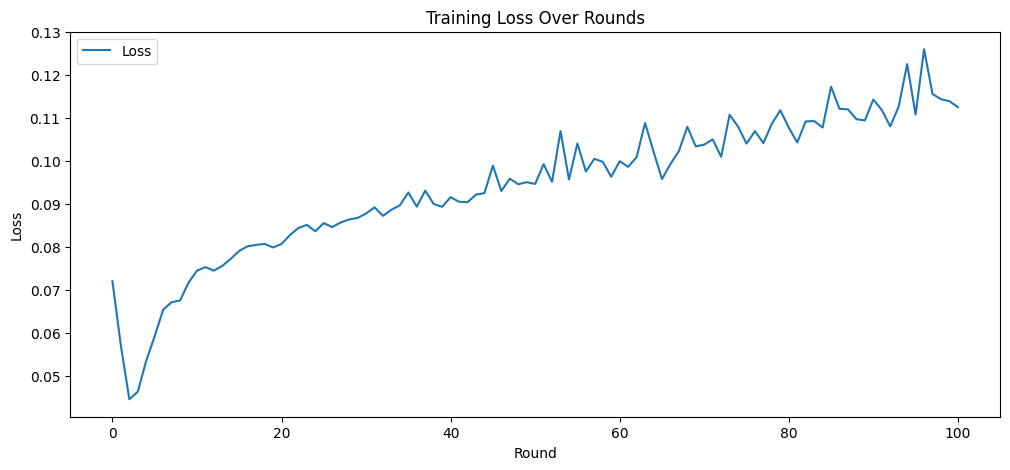

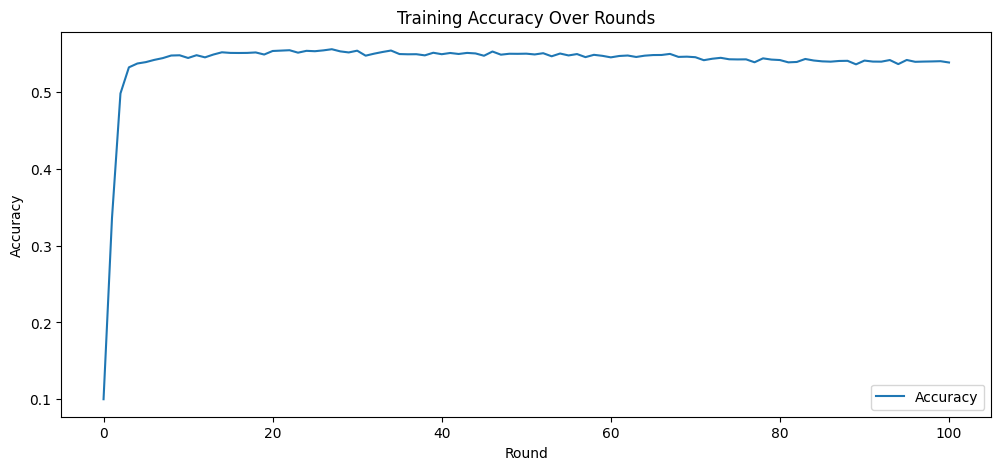

In [27]:
# Load the loss_history and accuracy_history from local storage
with open('history/fedprox_iid_loss_history.pkl', 'rb') as f:
    loss_history = pickle.load(f)
    print("loss_history loaded from loss_history.pkl")

with open('history/fedprox_iid_accuracy_history.pkl', 'rb') as f:
    accuracy_history = pickle.load(f)
    print("accuracy_history loaded from accuracy_history.pkl")



# Plot the results
# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(loss_history, label='Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Training Loss Over Rounds')
plt.legend()
#plt.xticks(range(len(loss_history)))  # Add all x-axis points
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Rounds')
plt.legend()
#plt.xticks(range(len(accuracy_history)))  # Add all x-axis points
plt.show()